# Import libraries

In [2]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

path = os.getcwd() + '/'

# Read file with labels

In [3]:
# Import data from csv
data = pd.read_csv(path +'conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [4]:
# Set function to remove outliers and apply it
def remove_outliers(df,column,n_std):
    mean = df[column].mean()
    sd = df[column].std()
        
    df = df[(df[column] <= mean+(n_std*sd))]
    df = df[(df[column] <= mean-(n_std*sd))]
        
    return df

In [5]:
# Remove outliers
remove_outliers(data, "age", 3)
remove_outliers(data, "total_pages_visited", 3)

,country,age,new_user,source,total_pages_visited,converted


# Explore dataset

In [6]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

In [7]:
# Isolate the target variable to do some EDA
data_sample_converted = data_sample[data_sample["converted"] == 1]

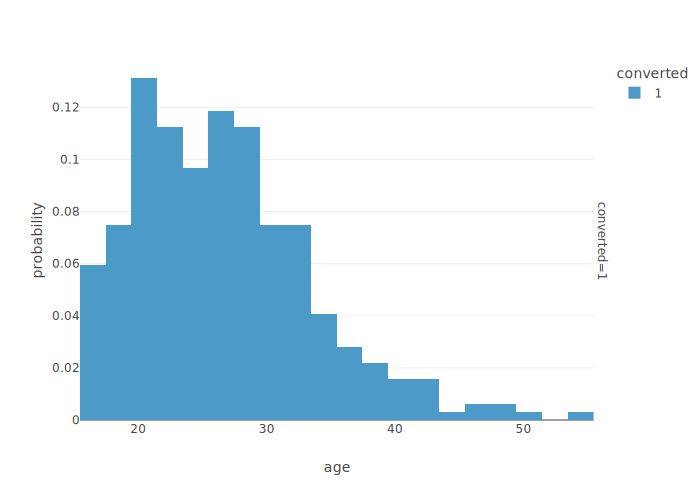

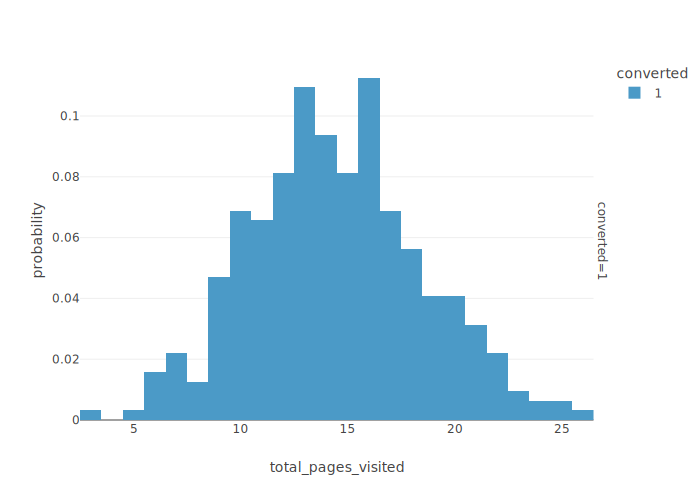

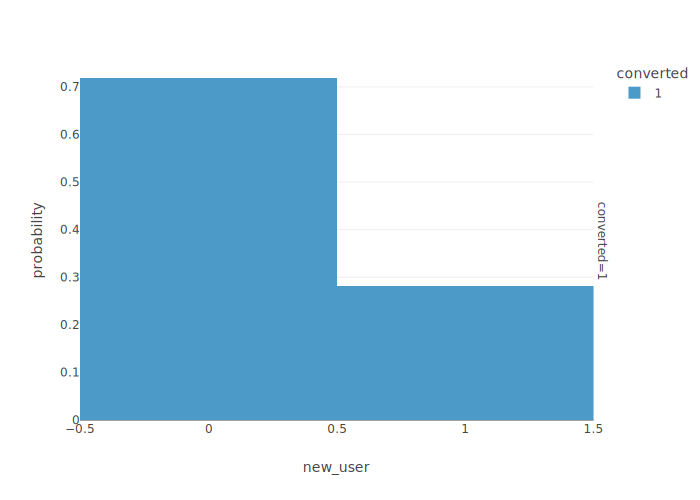

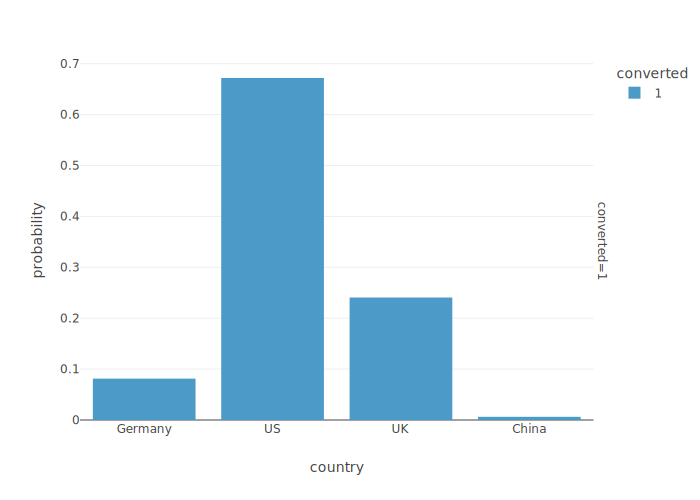

In [45]:
# Univariate analysis
# Distribution of each variable to understand the profile of users who converted to the website
num_features = ['age', 'total_pages_visited', 'new_user', 'country']
for f in num_features:
    fig = px.histogram(data_sample_converted, f, color = 'converted', facet_row = 'converted', histnorm = 'probability')
    fig.show()

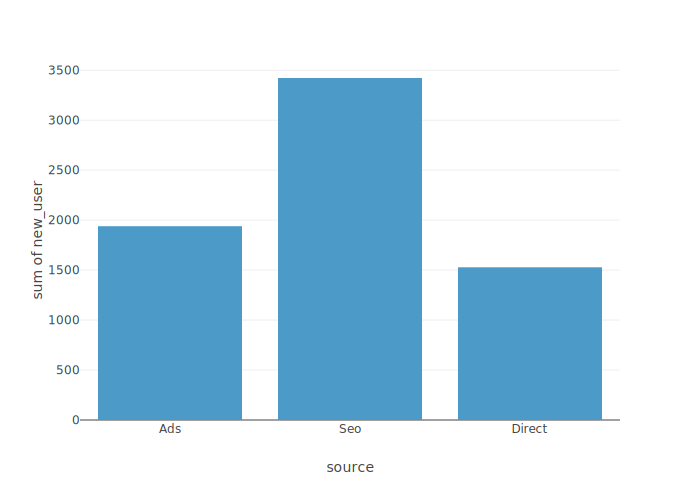

In [11]:
# Source of new user
px.histogram(data_sample, x="source", y="new_user")

In [47]:
# Display basic info on the dataset
print("Number of rows : {}".format(data_sample.shape[0]))
print()

print("Display of dataset: ")
display(data_sample.head())
print()

print("Basics statistics: ")
data_desc = data_sample.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*data_sample.isnull().sum()/data_sample.shape[0])

Number of rows : 10000

Display of dataset: 


,country,age,new_user,source,total_pages_visited,converted
38548,US,23,1,Seo,4,0
253236,UK,53,1,Ads,5,0
236274,US,33,1,Direct,1,0
44185,China,35,0,Direct,5,0
120294,US,28,0,Direct,3,0



Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,10000,10000.000000,10000.000000,10000,10000.000000,10000.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,5712,NaN,NaN,4945,NaN,NaN
mean,NaN,30.597400,0.683000,NaN,4.861200,0.032000
std,NaN,8.274621,0.465331,NaN,3.306513,0.176009
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

# Make your model

## Preprocessing and train/test split

In [48]:
# Features categorization (numeric/categorical)
features_list = ['total_pages_visited', 'age', 'country', 'new_user', 'source']
numeric_indices = [0, 1]
categorical_indices = [2, 3, 4]
target_variable = 'converted'

In [49]:
# Declare targets and features in dataset
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['total_pages_visited', 'age', 'country', 'new_user', 'source'], dtype='object')



In [50]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [51]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[[2 23 'China' 0 'Direct']
 [2 28 'China' 0 'Ads']
 [7 30 'China' 1 'Seo']
 [3 37 'UK' 1 'Seo']
 [8 31 'US' 1 'Ads']]
[[14 24 'China' 1 'Ads']
 [5 35 'US' 0 'Direct']]

[0 0 0 0 0]
[0 0]


## Training pipeline

In [52]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])
# Create pipeline for categorical features
# Names of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices),
        ('cat', categorical_transformer, categorical_indices)
    ])

In [53]:
# Fit and tansform X_train
print("Encoding categorical features and standardizing numerical features...")


X_train = preprocessor.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.85939501 -0.91458053  0.          0.          0.          0.
   1.          0.        ]
 [-0.85939501 -0.30994956  0.          0.          0.          0.
   0.          0.        ]
 [ 0.63639894 -0.06809718  0.          0.          0.          1.
   0.          1.        ]
 [-0.56023622  0.77838618  0.          1.          0.          1.
   0.          1.        ]
 [ 0.93555773  0.05282902  0.          0.          1.          1.
   0.          0.        ]]


## Test pipeline

In [54]:
# Fit X_test

print("Encoding categorical features and standardizing numerical features...")

X_test = preprocessor.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 2.73051047 -0.79365434  0.          0.          0.          1.
   0.          0.        ]
 [ 0.03808136  0.53653379  0.          0.          1.          0.
   1.          0.        ]
 [-0.26107743 -0.18902337  0.          0.          1.          0.
   1.          0.        ]
 [ 0.93555773  0.05282902  0.          0.          0.          1.
   0.          1.        ]
 [-0.85939501 -0.30994956  0.          0.          1.          1.
   0.          1.        ]]


# Model Training

After testing multiple model, the best perfoming one is the decision tree classifier

In [55]:
# Train model
print("Train model...")
classifier = DecisionTreeClassifier() # 
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [56]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [57]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [58]:
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7983466594389484
f1-score on test set :  0.7198038013488657


In [59]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.9883805374001452
accuracy on test set :  0.9839412467495959

f1-score on training set :  0.7983466594389484
f1-score on test set :  0.7198038013488657



In [60]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[247255    605]
 [  2371   5891]]

Confusion matrix on test set : 
[[27414   126]
 [  331   587]]



**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [61]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

DecisionTreeClassifier()

In [62]:
# Read data without labels
data_without_labels = pd.read_csv(path + 'conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)

X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[[16 28 'UK' 0 'Seo']
 [5 22 'UK' 1 'Direct']
 [1 32 'China' 1 'Seo']
 [6 32 'US' 1 'Ads']
 [3 25 'China' 0 'Seo']]


In [63]:
data_without_labels

,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3
...,...,...,...,...,...
31615,Germany,25,1,Seo,3
31616,US,36,1,Ads,7
31617,UK,33,1,Seo,5
31618,UK,25,1,Seo,14


In [64]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 3.32882805 -0.30994956  0.          1.          0.          0.
   0.          1.        ]
 [ 0.03808136 -1.03550673  0.          1.          0.          1.
   1.          0.        ]
 [-1.1585538   0.17375521  0.          0.          0.          1.
   0.          1.        ]
 [ 0.33724015  0.17375521  0.          0.          1.          1.
   0.          0.        ]
 [-0.56023622 -0.67272814  0.          0.          0.          0.
   0.          1.        ]]


In [65]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('Simple_tree_conversion_data_test_predictions.csv', index=False)


## Path for improvements in this case:

Feature selection: THe most obvious path for improvement would be to reduce the number of inco,nming features. Previous attempts showed that the first solution would be to remove the "source" feature.

Ensembling: Second solution would be to try enesmbling methods such as bagging by training multiple decision trees on different subsets of the training data or boosting by training multiple decision trees sequentially where each subsequent tree is trained on the residuals of the previous tree.